In [63]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

In [64]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'
print INSTRUMENT

tag = '-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'
    

hera47
Run IPython


In [65]:
len(sys.argv)

3

In [66]:
####################################################
################data file and load beam##############
####################################################

if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#tlist will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = True
	Use_Simulation_noise = True
	Keep_Red = False
	
	pre_calibrate = True
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 0.#tlist will be wrapped around [lst_offset, 24+lst_offset]
	
	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz
	
	S_type = 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
			model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
			 model_pols) = hc.abscal.UVData2AbsCalDict([model_fname1, model_fname2], return_meta=True)
			
			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA") #zen.2457698.40355.xx.HH.uvcA
		(data, dflags, antpos, ants, data_freqs, data_times, data_lsts, 
		 data_pols) = hc.abscal.UVData2AbsCalDict(data_fname, return_meta=True)
		
		data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		data_fname = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
		(data, dflags, antpos, ants, data_freqs, data_times, data_lsts, 
		 data_pols) = hc.abscal.UVData2AbsCalDict(data_fname, return_meta=True)
		
		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object

	# make wgts
	wgts = copy.deepcopy(dflags)
	for k in wgts.keys():
		wgts[k] = (~wgts[k]).astype(np.float)
		
	wgts_yy = copy.deepcopy(dflags_yy)
	for k in wgts_yy.keys():
		wgts_yy[k] = (~wgts_yy[k]).astype(np.float)

	antloc = np.array(map(lambda k: antpos[k], ants))
	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	bls[0] = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in data.keys()])
	bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
	bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	vis_data_xx_mfreq = np.array([data[bslkeys] for bslkeys in data.keys()], dtype='complex128').transpose((2,1,0))
	vis_data_yy_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
	vis_data_mfreq[0] = vis_data_xx_mfreq
	vis_data_mfreq[1] = vis_data_yy_mfreq
	
	flist = np.array(data_freqs)/10**6
	try:
		index_freq = np.where(flist==150)[0][0]
#		index_freq = 512
	except:
		index_freq = 0
	vis_freq_selected = freq = flist[index_freq] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz
	vis_data = vis_data_mfreq[:,index_freq,:,:] # [pol, freq, time, bl] 

		
	############################## Autocorrelation #################################
	xxfile = data_fname
	yyfile = data_fname_yy
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	if not Small_ModelData:
		try:
			plot_data_autocorr = False
			if plot_data_autocorr: # at specific frequency
				### plot autos
				t_index = 0
				jd = times[t_index]
				utc = Time(jd, format='jd').datetime

				xlim = (-50, Nfreqs+50)
				ylim = (-10,30)

				fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
				fig.subplots_adjust(wspace=0.2, hspace=0.2)
				fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
				fig.tight_layout(rect=(0, 0, 1, 0.95))

				k = 0
				for i in range(Yside):
					for j in range(Nside):
						ax = axes[i,j]
						ax.set_xlim(xlim)
						ax.set_ylim(ylim)
						if k < Nants:
							px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
							py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
							ax.grid(True, which='both')
							ax.set_title(str(ants[k]), fontsize=14)
							if k == 0:
								ax.legend([px, py], ['East', 'North'], fontsize=12)
						else:
							ax.axis('off')
						if j != 0:
							ax.set_yticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_yticklabels()]
							ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
						if i != Yside-1:
							ax.set_xticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_xticklabels()]
							ax.set_xlabel('freq channel', fontsize=14)

						k += 1
				plt.show(block=False)
			
			autocorr_data_mfreq = np.zeros((2, Ntimes, Nfreqs))
			autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
			autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
			autocorr_data = autocorr_data_mfreq[:,:,index_freq]	
		
		except:
			pass
	
	
	
	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	Ubl_list_raw[0] = np.array(omnical.arrayinfo.compute_reds_total(antloc)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	ant_pos = [[],[]]
	ant_pos[0] = antpos
	ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
			
	Nubl_raw = np.zeros(2, dtype=int)
	Nubl_raw[0] = len(Ubl_list[0])
	Nubl_raw[1] = len(Ubl_list[1])

	
	bs_position_list = [[],[]]
	for i in range(2):
		for bs in range(len(bsl_coord[i])):			
			bs_position = [] #np.zeros((len(bsl_coord[i]))			
			for index in range(len(red_bls)):
				try:
					if np.where(np.array(red_bls[index])==(bls[i].keys()[bs][0],bls[i].keys()[bs][1]))[0][0] == np.where(np.array(red_bls[index])==(bls[i].keys()[bs][0],bls[i].keys()[bs][1]))[0][1]:
						order = np.where(np.array(red_bls[index])==(bls[i].keys()[bs][0],bls[i].keys()[bs][1]))[0][0]
						bs_position.append([index, order])
				except:
					pass
			bs_position_list[i].append(bs_position)
	
	times_raw = np.zeros(2, dtype=int)
	times_raw[0] =  len(data_times)
	times_raw[1] =  len(data_times_yy)
	
	times_raw_list = [[],[]]
	times_raw_list[0] =  data_times
	times_raw_list[1] =  data_times_yy
	
	redundancy = [[],[]]
	
	bsl_coord_dred = [[],[]]
	bsl_coord_dred[0] = np.zeros((Nubl_raw[0], 3))
	bsl_coord_dred[1] = np.zeros((Nubl_raw[1], 3))
	
	vis_data_dred = [[],[]]
	vis_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
	vis_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	for i in range(2):
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[0].transpose()[Ubl_list[0][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[0][i_ubl]], axis=0)
			redundancy[i].append(len(Ubl_list[0][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[0].transpose()[Ubl_list[0][i_ubl]].transpose(), axis=1)
			except:
				pass
	
	
	Del = True
	if Del and not Small_ModelData:
		try:
			del(uvd_xx)
			del(uvd_yy)
			del(aa)
			del(info)
			#del(red_bls)
			del(autocorr_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(vis_data)
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	tlist_JD = np.array(data_times)
	JD2SI_time = Time(data_times, format='jd').datetime
	tlist = np.zeros(len(data_times))
	nt = len(tlist)
	for i in range(len(data_times)):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))

	############################## Common UBL ###########################
	ubls = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	if Keep_Red:
		nUBL = len(bsl_coord)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	


>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [67]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname, data_fname_yy
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA
7


In [68]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

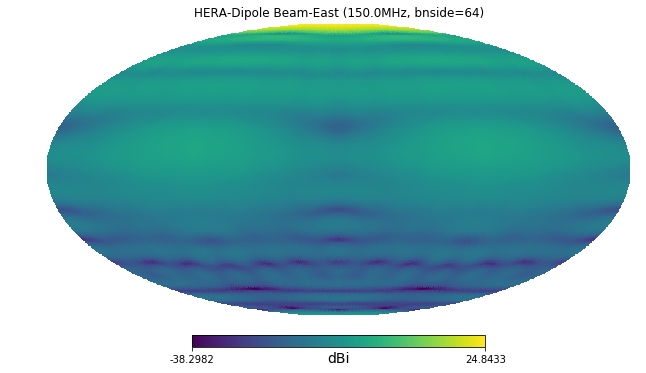

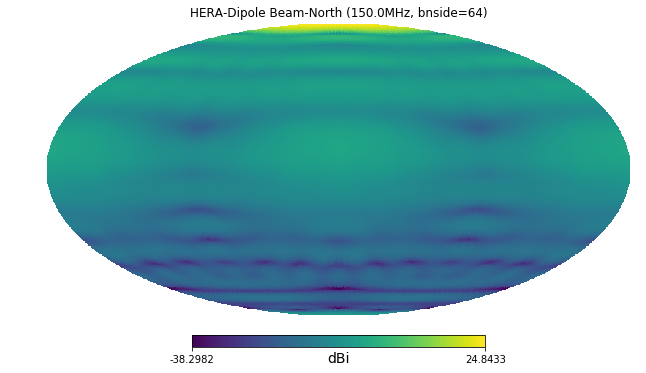

In [69]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [70]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


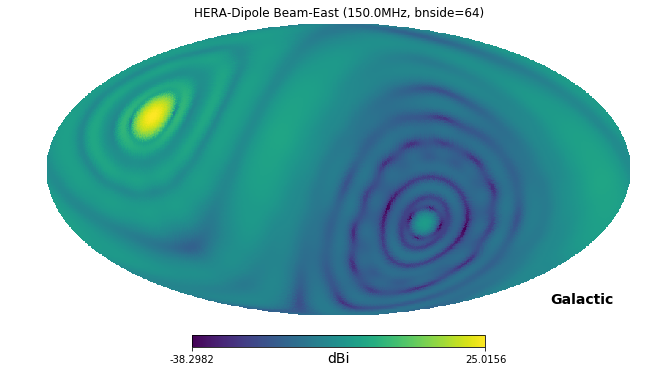

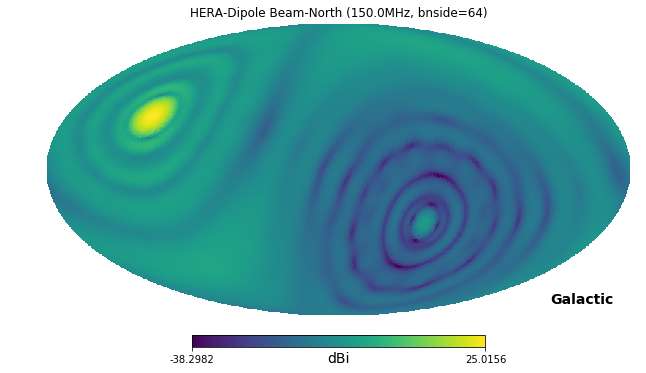

In [71]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


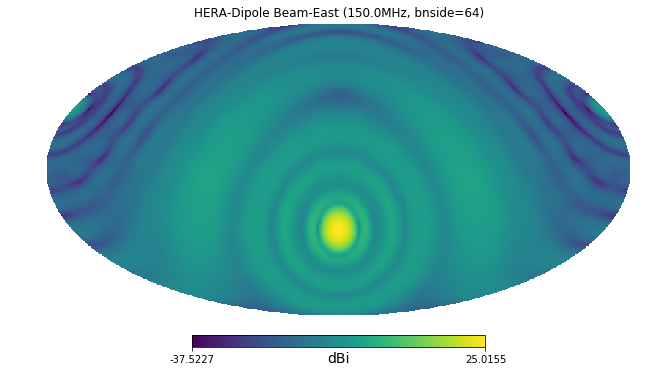

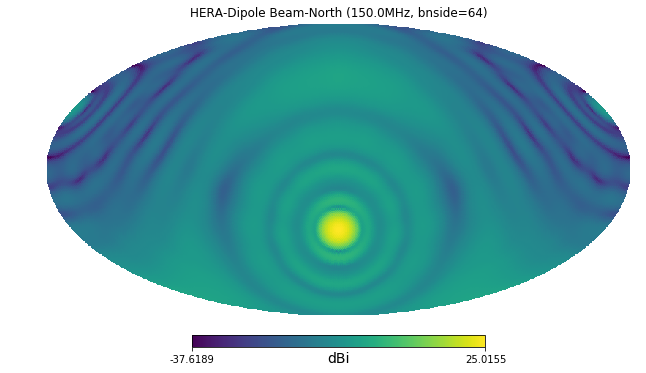

In [72]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

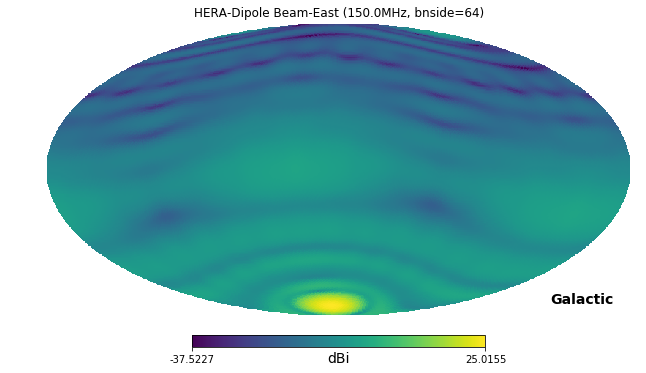

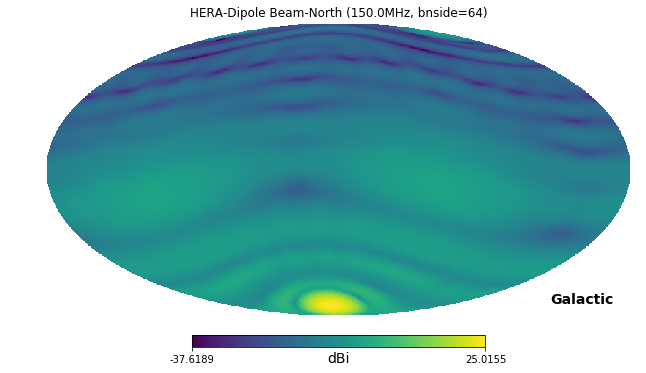

In [73]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [74]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	del(data)
	del(data_yy)
	try:
		del(model)
		del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [75]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=tlist).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()


################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",
sys.stdout.flush()
equ2013_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=2013.58))
ang0, ang1 = hp.rotator.rotateDirection(equ2013_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)

sys.stdout.flush()


9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [76]:
#print A.shape

In [77]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)

if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=tlist) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
#                 autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.real(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))



Simulating visibilities, 2018-02-22 23:20:09.481463, expected time 0.0 min simulated visibilities in 0.1 minutes.


In [78]:
print autocorr_vis.mean()
print fullsim_vis.mean()

2980482.3395806956
(4334.6174799487235-4633.067799684426j)


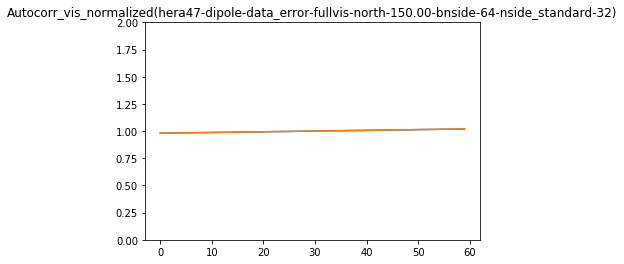

In [79]:
simulation_opt
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()

In [80]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])

pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
#if INSTRUMENT == 'miteor':
#	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
#	sys.stdout.flush()
#	timer = time.time()
#	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
#		for i, source in enumerate(pt_sources):
#			ra = southern_points[source]['body']._ra
#			dec = southern_points[source]['body']._dec
#			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=tlist) / 2


In [81]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

sys.stdout.flush()


In [82]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[i+1]-flist[i]) for i in range(len(flist)-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:
		noise['x'] = np.array([np.random.normal(0,autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0,autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0,autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) / np.array(redundancy[0])) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0,autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) / np.array(redundancy[1])) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten()
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			noise_data['x'] = np.array([(np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) / np.array(redundancy[0])) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten()
			noise_data['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) / np.array(redundancy[1])) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()			
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()

#N_acu['x'] = np.diag(1.e-6*np.ones(len(N_acu['x'])))
#A['x'] = np.diag(np.ones(len(A['x'])))
#
#Ni_acux = la.inv(N_acu['x'])
#AtNi = np.dot(A['x'].T,Ni_acux)
#AtNiA = np.dot(AtNi, A['x'])
#E_Corr = la.inv(AtNiA+np.diag(1.e-12*np.ones(len(AtNiA))))
#Sig_Err_Corr = np.dot( np.dot(E_Corr, AtNiA), E_Corr)
#P_matrix = np.dot(E_Corr, AtNiA)
#Dis = abs(equatorial_GSM_standard[::4] - np.dot(P_matrix,equatorial_GSM_standard[::4]))
#Dis_Ratio = Dis / np.diag(abs(Sig_Err_Corr)**0.5)

In [83]:
#print noise['x']

In [84]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename
for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				Ni[pol] = 1. / (N_data['p'])[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()


# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

##################### Delete Vis_data #######################
Del = True
if Del:
	try:
		del(vis_data)
		del(vis_data_dred)
	except:
		pass
	try:
		del(N_data)
	except:
		pass
	try:
		del(var_data)
	except:
		pass
#	try:
#		del(var_data)
#	except:
#		pass

sys.stdout.flush()


def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 6305832.000MB


In [85]:
print Ni

[2.26312116e-05+0.j 2.20507329e-03+0.j 1.79396453e-05+0.j ...
 6.39888237e-05+0.j 3.68376890e-05+0.j 3.44931279e-04+0.j]


In [86]:
# pre_ampcal = False

In [87]:
# ################################
# ################################
# ####pre_calibrate################
# ################################
# ################################
# #####1. antenna based calibration#######
# if antpairs is not None:
# 	used_antpairs = antpairs[abs(ubl_index['x'])-1]
# 	n_usedants = np.unique(used_antpairs)
# #####2. re-phasing and crosstalk#######
# additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

# #put in autocorr regardless of whats saved on disk
# for p in range(2):
# 	additive_A[:, p, :, 0] = fullsim_vis[:, p]
# 	for i in range(nUBL_used):
# 		additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
# 		additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
# additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

# if pre_calibrate:
# 	import omnical.calibration_omni as omni
# 	raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
# 	#raw_Ni = np.copy(Ni)

# 	real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
# 	if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
# 		n_prefit_amp = 2
# 		real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
# 		real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
# 		for i in range(n_prefit_amp):
# 			real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
# 		real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
# 		real_additive_A = real_additive_A_expand
# 		real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
# 	else:
# 		n_prefit_amp = 1

# 	additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
# 	if pre_addcal:
# 		ATNIA(real_additive_A, Ni, additive_AtNiA)
# 		additive_AtNiAi = sla.inv(additive_AtNiA)
# 	else:
# 		real_additive_A[..., n_prefit_amp:] = 0.
# 		ATNIA(real_additive_A, Ni, additive_AtNiA)
# 		additive_AtNiAi = sla.pinv(additive_AtNiA)

# 	niter = 0
# 	rephases = np.zeros((2,2))
# 	additive_term = np.zeros_like(data)
# 	additive_term_incr = np.zeros_like(data)
# 	while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 50:
# 		niter += 1

# 		if pre_phscal:
# 			cdata = get_complex_data(data)
# 			for p, pol in enumerate(['xx', 'yy']):
# 				#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
# 				rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
# 				rephases[p] = rephase
# 				if p == 0:
# 					print 'pre process rephase', pol, rephase,
# 				else:
# 					print pol, rephase
# 				cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
# 			data = stitch_complex_data(cdata).astype('complex128')

# 		additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
# 		print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
# 		additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
# 		data -= additive_term_incr
# 		additive_term += additive_term_incr
# 		print "additive fraction", la.norm(additive_term_incr) / la.norm(data),



# 	if pre_ampcal:
# 		data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
# 		Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
# 		additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])

# 	print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
# 	np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
# 			 data=data,
# 			 simdata=stitch_complex_data(fullsim_vis),
# 			 psdata=[stitch_complex_data(vis) for vis in pt_vis],
# 			 pt_sources=pt_sources,
# 			 ubls=used_common_ubls,
# 			 tlist=tlist,
# 			 Ni=Ni,
# 			 freq=freq)
 


In [88]:
print additive_sol[:2]

[ 1.00000000e+00+0.j -8.06267053e-10+0.j]


In [89]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

574741.6310404198
574741.6310405072
574741.63104042
1.000000000000152

106.4289849721324
[3683.44438758+0.j 3550.57543295+0.j 3410.85837379+0.j ...
 1172.10478761+0.j 1145.46111695+0.j 1118.95816862+0.j]
[[[ 3683.44438758 -3769.71974969j  3550.57543295 -3986.19943277j
    3410.85837379 -4199.12824502j ... -6708.8124899  -4856.90785634j
   -6853.15399073 -4763.02279957j -6995.18389786 -4665.28305154j]
  [  379.54436248 -2853.75192107j   248.76790905 -3065.02217062j
     111.52942949 -3272.36056231j ... -9502.43454728 -4476.13679955j
   -9658.96485826 -4393.96176569j -9813.67669193 -4306.94071945j]]

 [[-9577.59624076 +4016.58746189j -9532.00738723 +4067.92844952j
   -9484.21833129 +4117.90817236j ... -5571.38417771 +3000.84507363j
   -5578.69948952 +2873.01386978j -5594.30418748 +2746.62473061j]
  [-5464.95738022 +3445.68427905j -5398.24084176 +3515.38443621j
   -5328.09980659 +3581.68702516j ... -1759.79578903 +1757.20396614j
   -1799.15234957 +1642.71372746j -1845.61918144 +1531.28437

In [90]:
pre_ampcal = True

Estimated time for A 2160 by 37 3.844152e-05 minutes pre process rephase xx [0. 0.] yy [0. 0.]
>>>>>>>>>>>>>additive fitting amp [1.+0.j] additive fraction 7.99506937374823e-14 saving data to /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts/../Output/hera47hera47-150.000000-ampcal-_2016_01_20_avg_2016_01_20_avgx100_gsmcal_n32_bn64.npz


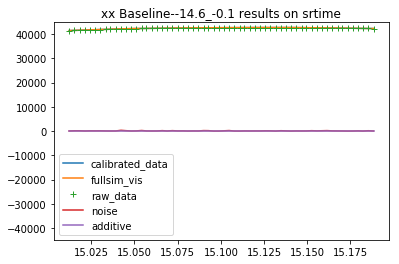

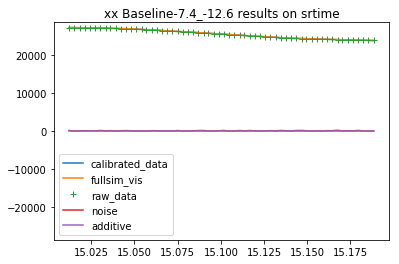

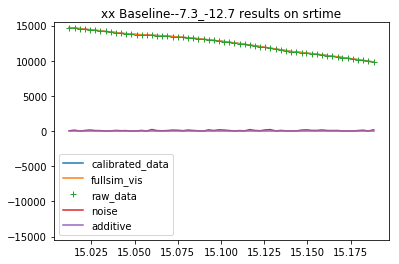

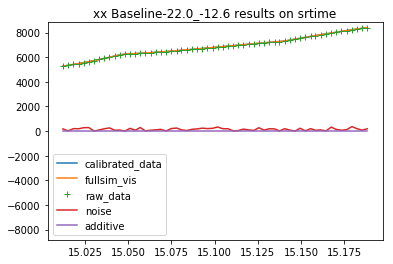

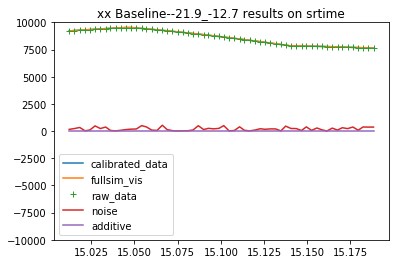

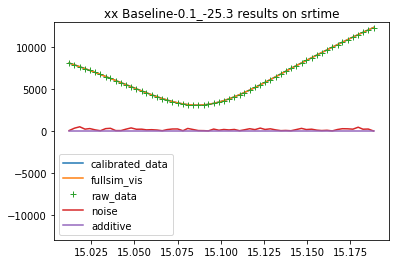

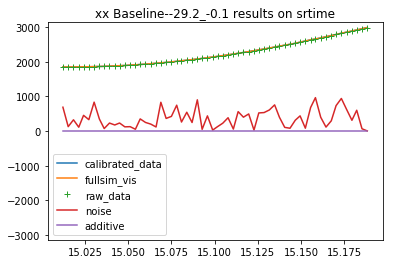

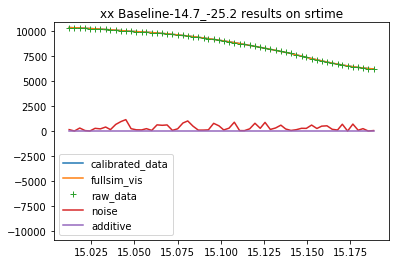

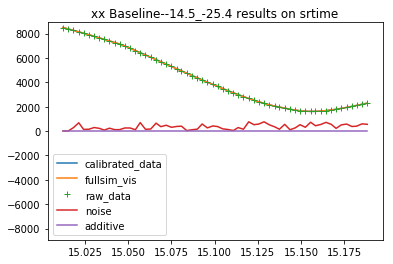

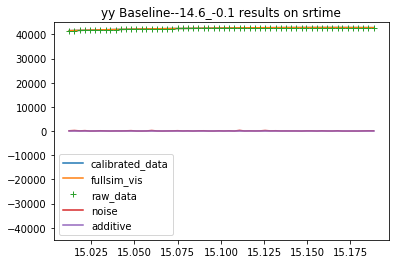

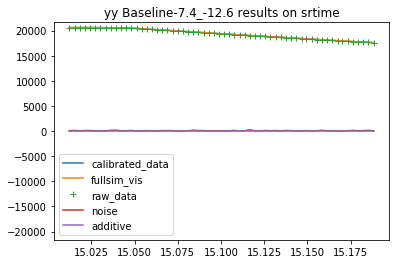

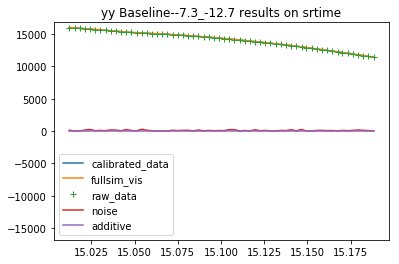

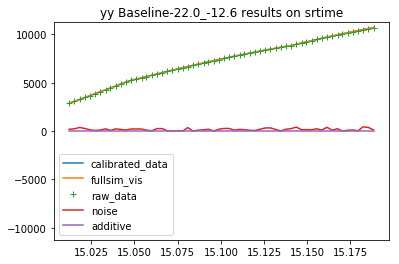

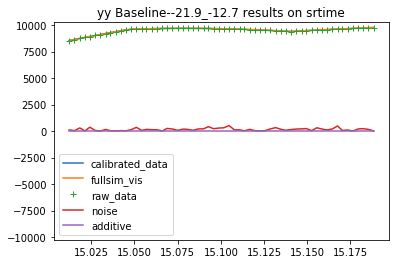

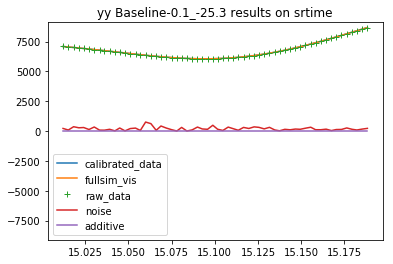

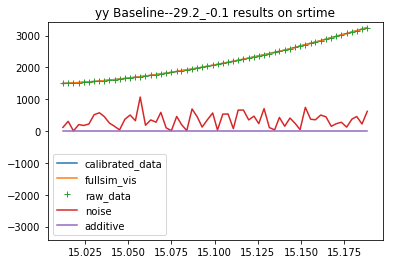

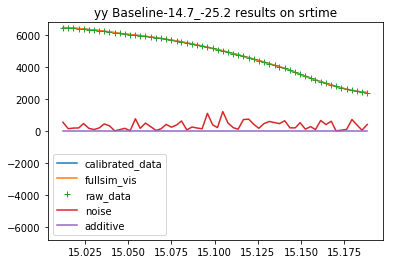

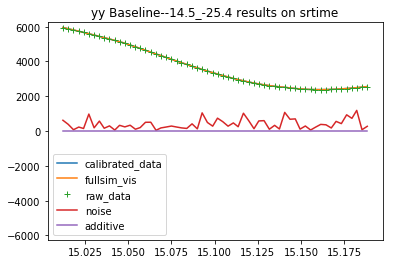

Estimated time for A 2160 by 37 3.844152e-05 minutes pre process rephase xx [-2.18690489e-16 -3.43413822e-15] yy [-1.00464612e-15  1.36729092e-15]
>>>>>>>>>>>>>additive fitting amp [1.+0.j] additive fraction 2.7311840711923383e-13 saving data to /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts/../Output/hera47hera47-150.000000-ampcal-_2016_01_20_avg_2016_01_20_avgx100_gsmcal_n32_bn64.npz


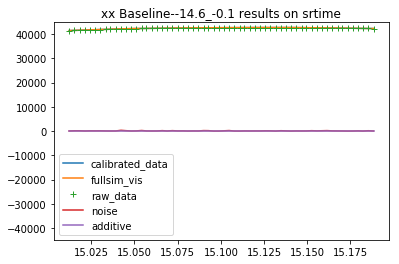

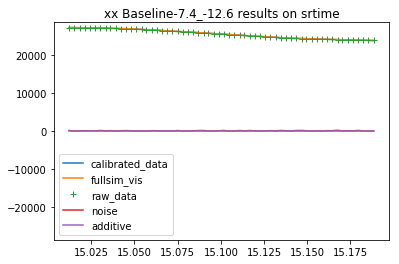

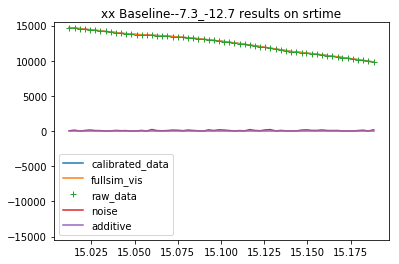

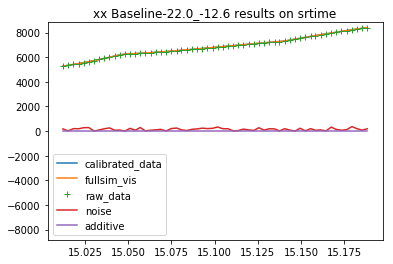

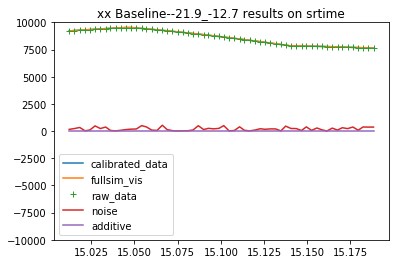

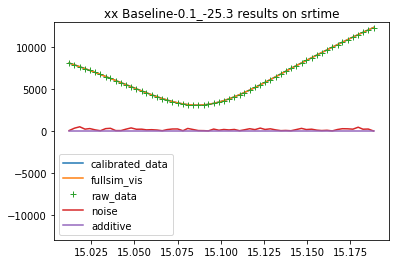

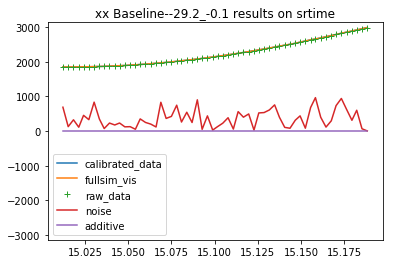

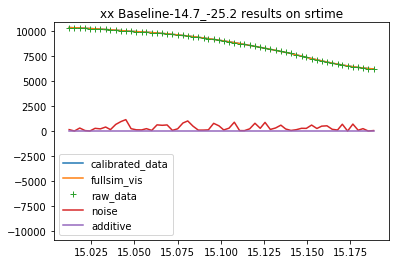

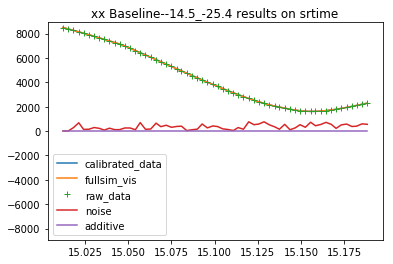

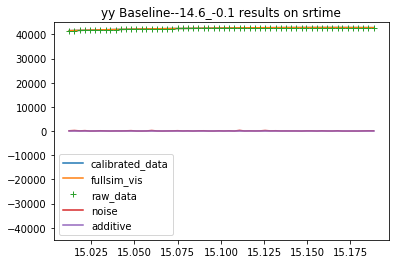

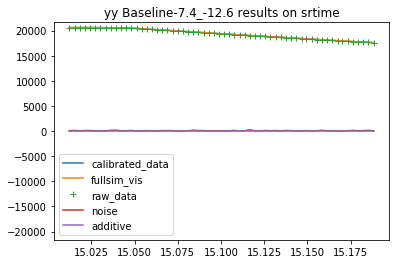

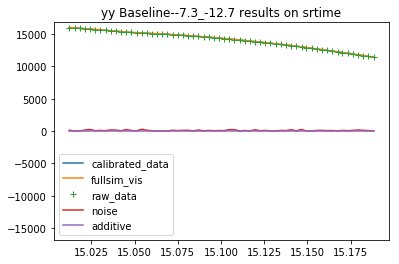

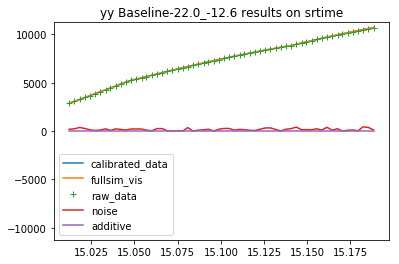

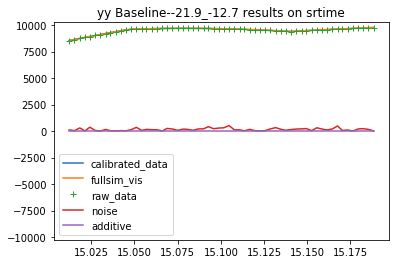

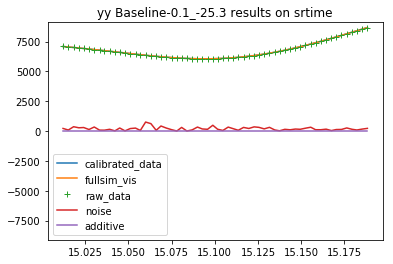

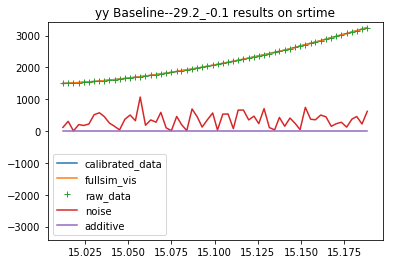

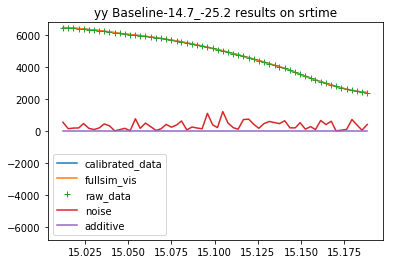

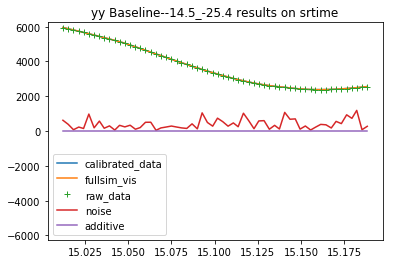

In [91]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(2):
	if pre_ampcal:
		pre_ampcal = False if cal_index == 0 else True
		cal_index += 1
	else:
		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		import omnical.calibration_omni as omni
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 50:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),



		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])

	print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
	np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
			 data=data,
			 simdata=stitch_complex_data(fullsim_vis),
			 psdata=[stitch_complex_data(vis) for vis in pt_vis],
			 pt_sources=pt_sources,
			 ubls=used_common_ubls,
			 tlist=tlist,
			 Ni=Ni,
			 freq=freq)


	if plot_data_error:
		#plt.clf()
		
		cdata = get_complex_data(data)
		crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
		cNi = get_complex_data(Ni)
		cadd = get_complex_data(additive_term)

		fun = np.abs
		srt = sorted((tlist - lst_offset)%24.+lst_offset)
		asrt = np.argsort((tlist - lst_offset)%24.+lst_offset)
		pncol = min(int(60. / (srt[-1] - srt[0])), 12)
		us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
		figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
			
			#plt.figure(500+10*p)
			#plt.subplots_adjust(hspace=1.2,wspace=0.7)
			for nu, u in enumerate(us):
				plt.figure(5000+100*p+nu)
				#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
				figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
				figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
				if pre_calibrate:
					figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.ylim([-1.05*data_range, 1.05*data_range])
				if pre_calibrate:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
				plt.show(block=False)
			
			
			#plt.gcf().clear()
			#plt.clf()
			#plt.close()


In [92]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.9999999999997333+0j) (5.268674385661143e-10+0j) 1
(1+0j)
[[1.+0.j]]
False


In [93]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

574741.6310402706
574741.6310404158
574741.63104042
1.00000000000026
106.4289849721324
[2.26312116e-05+0.j 2.20507329e-03+0.j 1.79396453e-05+0.j ...
 6.39888237e-05+0.j 3.68376890e-05+0.j 3.44931279e-04+0.j]
(75.1892206441823+0j)
[210.20647897+0.j  21.29553158+0.j 236.09841655+0.j ... 125.01091577+0.j
 164.76076935+0.j  53.84355303+0.j]


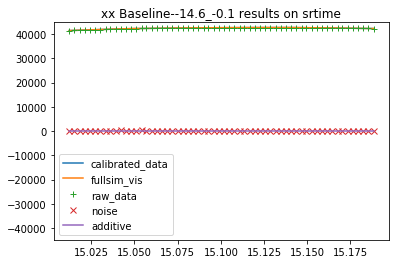

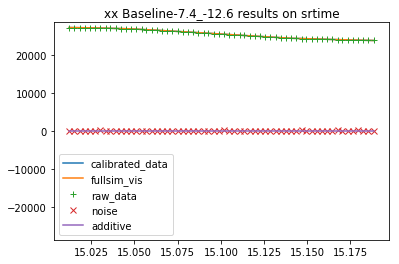

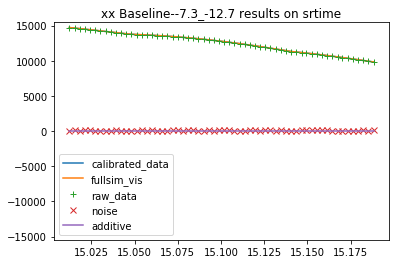

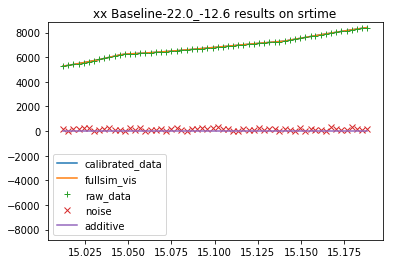

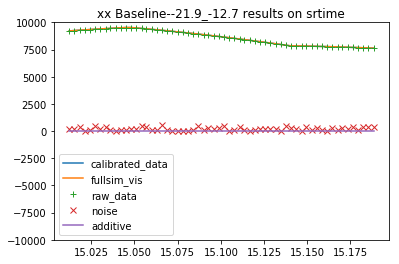

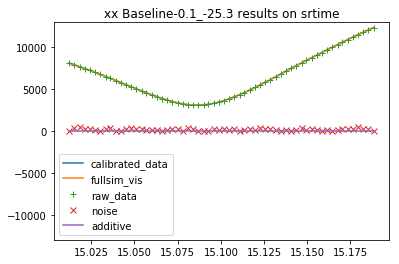

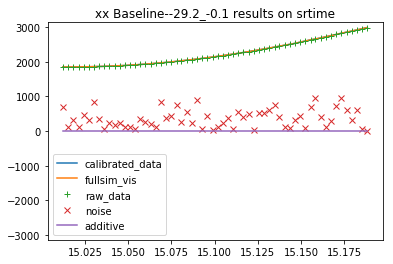

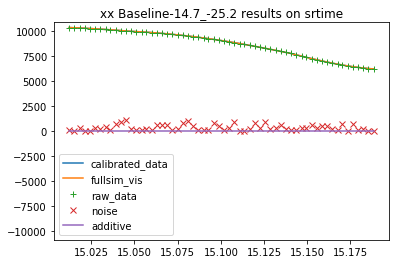

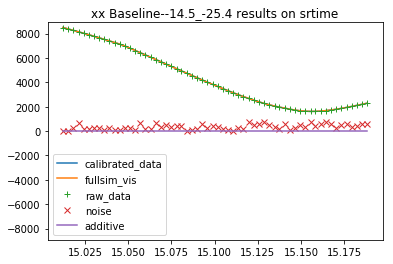

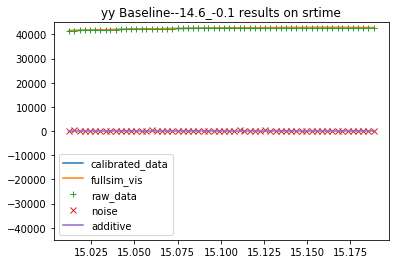

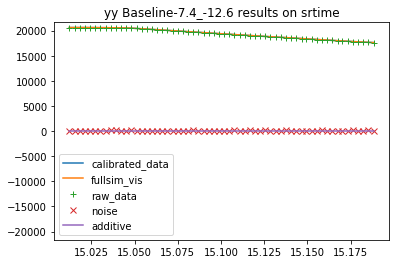

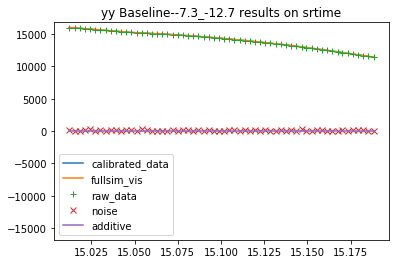

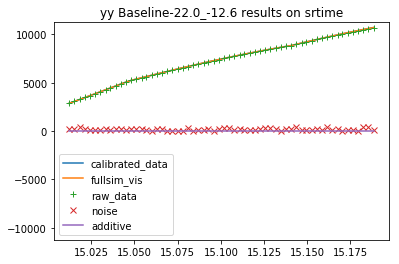

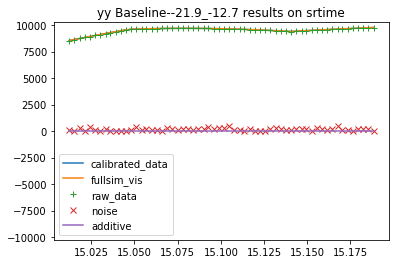

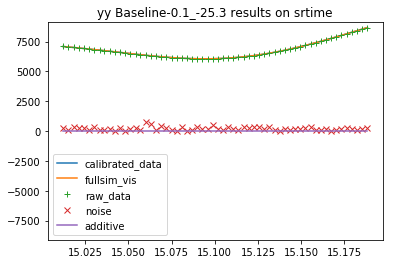

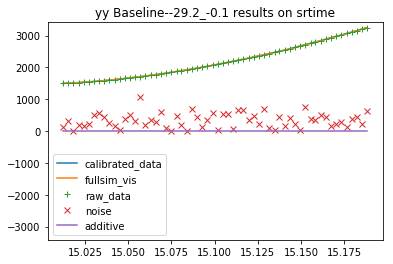

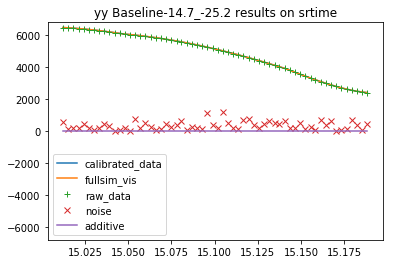

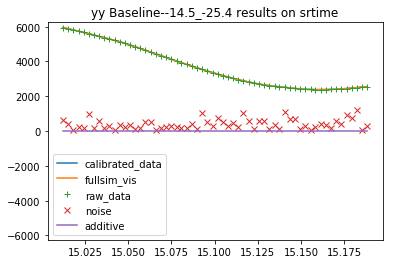

In [94]:
if plot_data_error:
    #plt.clf()

    cdata = get_complex_data(data)
    crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
    cNi = get_complex_data(Ni)
    cadd = get_complex_data(additive_term)

    fun = np.abs
    srt = sorted((tlist - lst_offset)%24.+lst_offset)
    asrt = np.argsort((tlist - lst_offset)%24.+lst_offset)
    pncol = min(int(60. / (srt[-1] - srt[0])), 12)
    us = ubl_sort['x']
    figure = {}
    
    for p in range(2):
        for nu, u in enumerate(us):
            plt.figure(5000+100*p+nu)
            #plt.subplot(5, (len(us) + 4) / 5, nu + 1)
            figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
            figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
            figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
            figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, 'x', label='Ni')
            if pre_calibrate:
                figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
                data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))])
            else:
                data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))])
            plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
            plt.ylim([-1.05*data_range, 1.05*data_range])
            if pre_calibrate:
                plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
            else:
                plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
            plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
            plt.show(block=False)


        #plt.gcf().clear()
        #plt.clf()
        #plt.close()

Del=True
if Del:
	del(crdata)
	del(cadd)
	del(cNi)
	del(cdata)
    

sys.stdout.flush()


In [95]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [96]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
# if AtNiA_only:
#     valid_npix = pixel_scheme_number
#     pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq)
#     fake_solution_map = pixel_scheme_file['gsm']
#     thetas = pixel_scheme_file['thetas']
#     phis= pixel_scheme_file['phis']
#     sizes= pixel_scheme_file['sizes']
#     nside_distribution= pixel_scheme_file['nside_distribution']
#     final_index= pixel_scheme_file['final_index']
#     npix = pixel_scheme_file['n_fullsky_pix']
#     valid_pix_mask= pixel_scheme_file['valid_pix_mask']
#     thresh= pixel_scheme_file['thresh']
# else:
nside_distribution = np.zeros(12 * nside_standard ** 2)
final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
thetas, phis, sizes = [], [], []
abs_thresh = np.mean(gsm_beamweighted) * thresh
pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
         final_index, thetas, phis, sizes)
npix = len(thetas)
valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
valid_npix = np.sum(valid_pix_mask)
print '>>>>>>VALID NPIX =', valid_npix

fake_solution_map = np.zeros_like(thetas)      
for i in range(len(fake_solution_map)):
    fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
fake_solution_map = fake_solution_map[valid_pix_mask]
sizes = np.array(sizes)[valid_pix_mask]
thetas = np.array(thetas)[valid_pix_mask]
phis = np.array(phis)[valid_pix_mask]
np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose





>>>>>>VALID NPIX = 8118


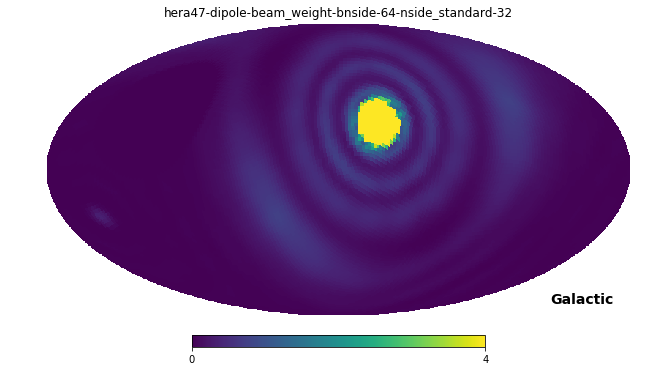

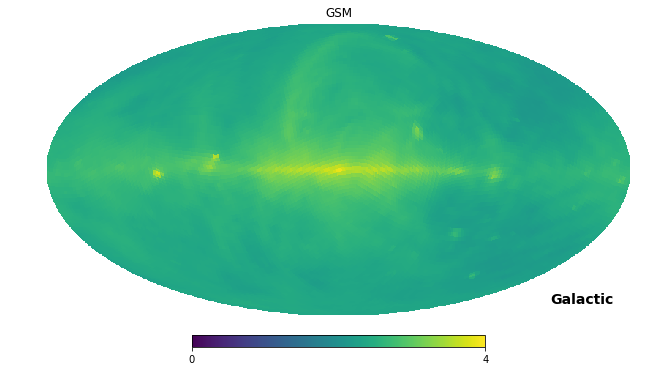

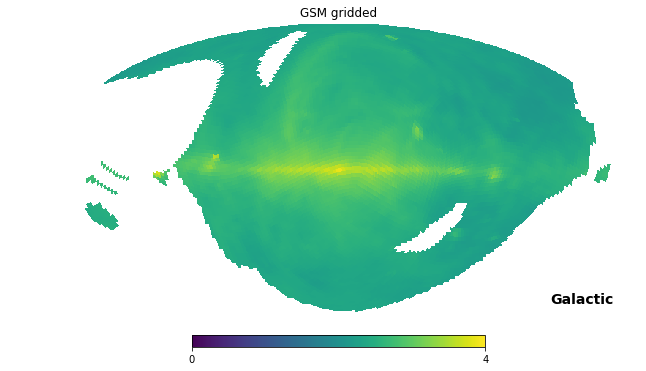

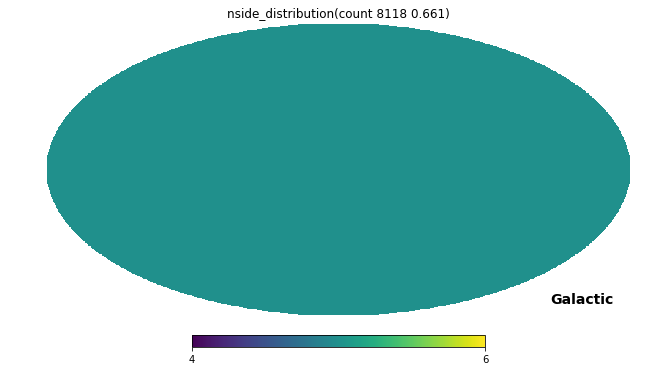

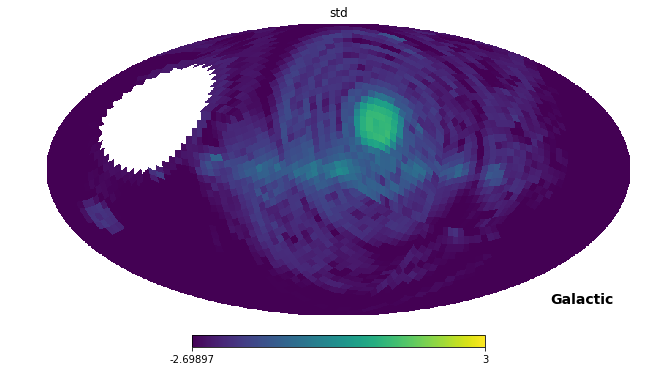

In [97]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

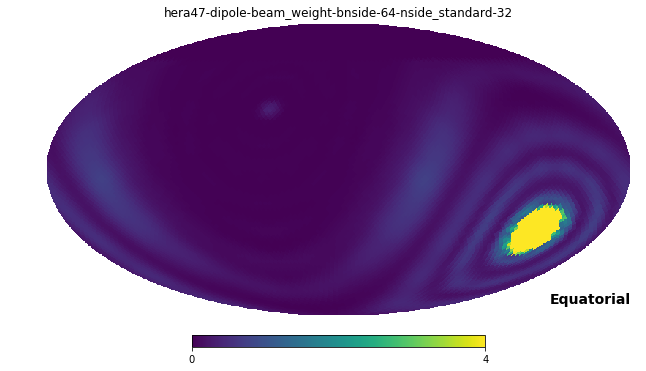

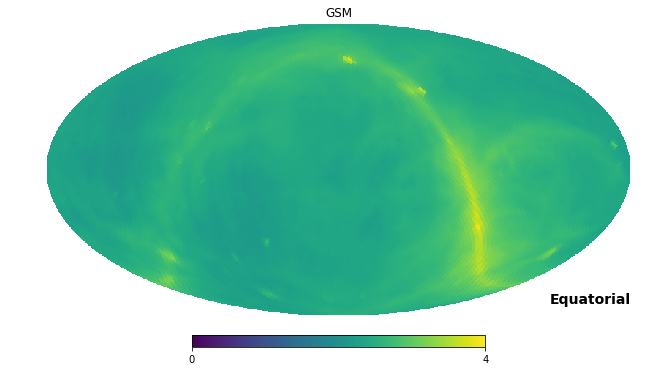

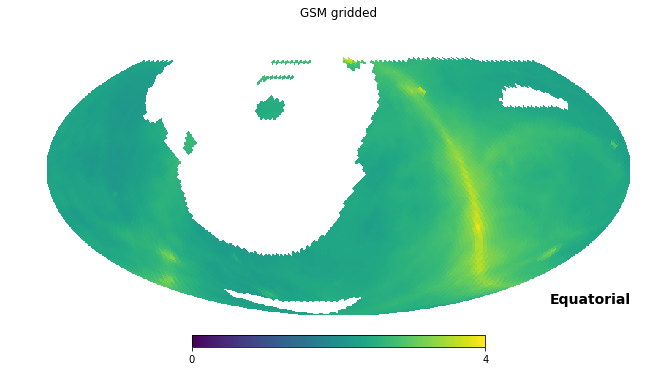

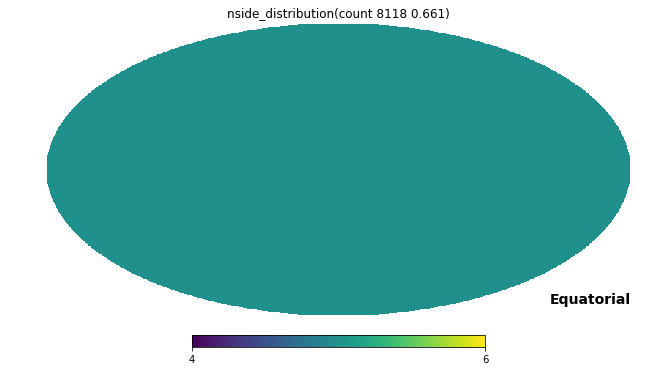

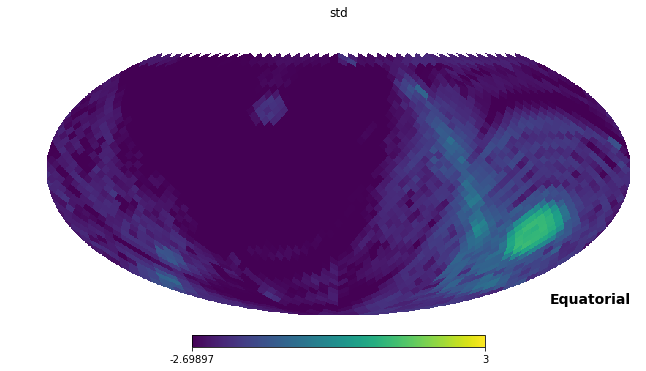

In [98]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [99]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A():
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=tlist) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=tlist) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')


A = get_A()
Ashape0, Ashape1 = A.shape

Del=True
if Del:
	try:
		del(additive_A)
		del(real_additive_A)
	except:
		pass


# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()



def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...
100.0% completed, 0.000039 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Memory usage: 6457171.000MB
Memory usage: 6457171.000MB


In [100]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [101]:
Integration_Time
np.sum(Ni**-1)**.5

(15972.749939646023+0j)

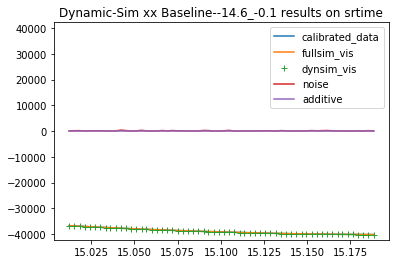

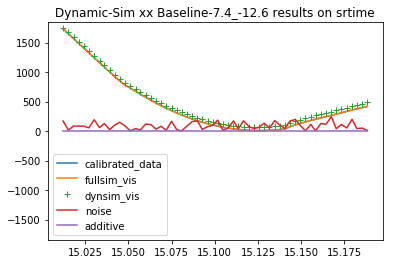

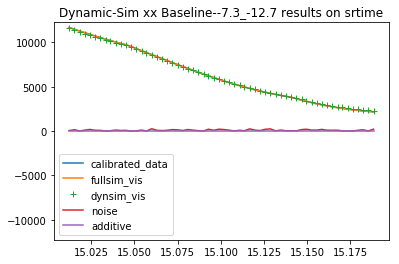

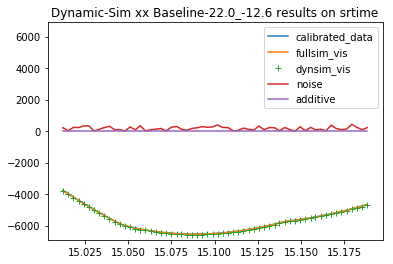

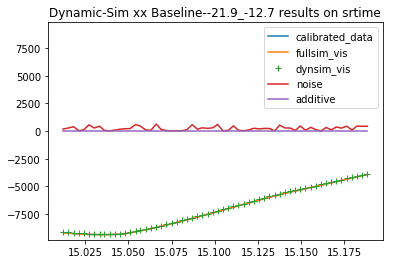

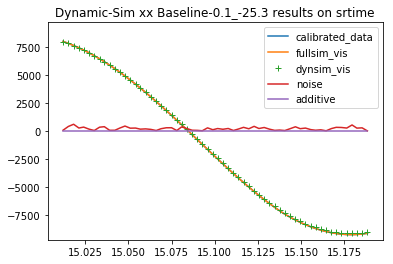

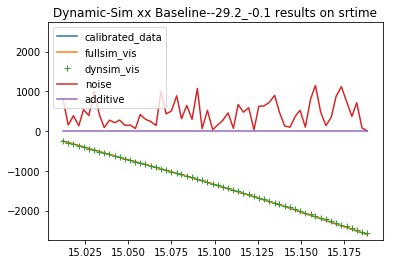

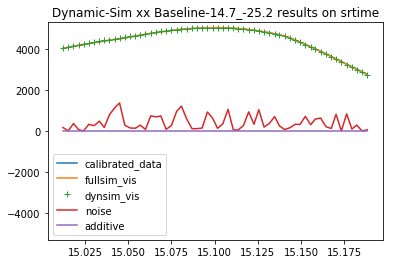

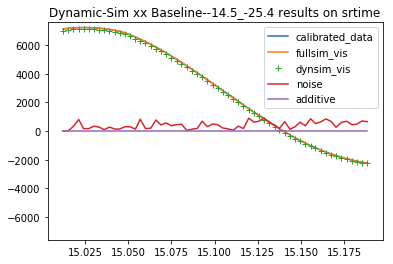

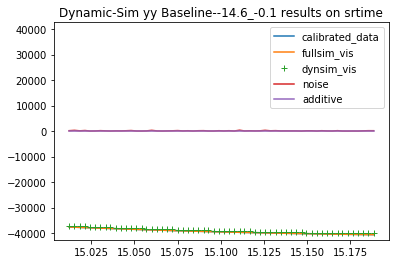

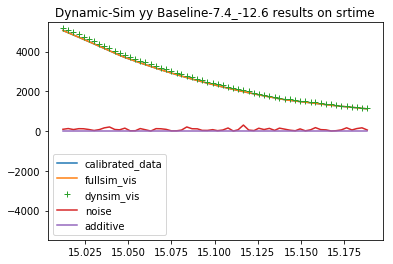

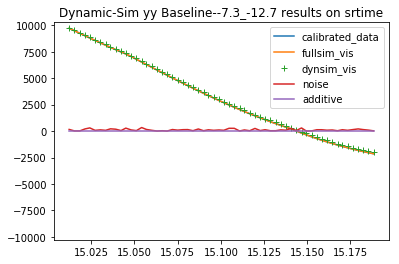

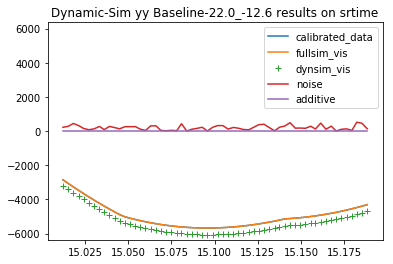

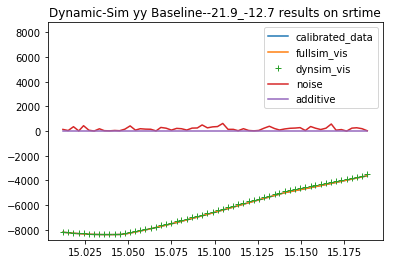

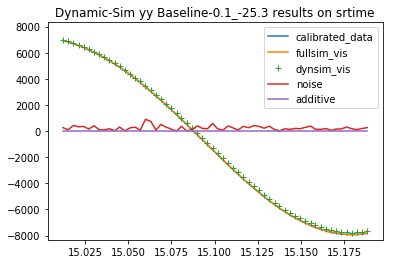

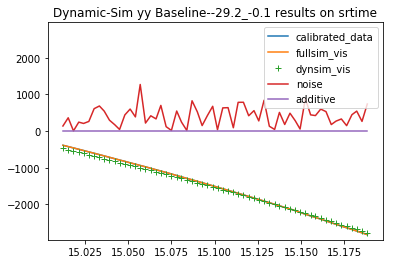

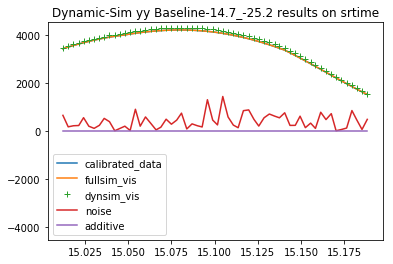

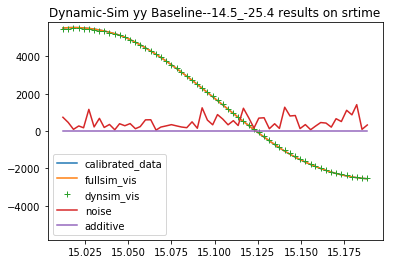

total deviation between dynamic and full sim compared to sim:  0.014529250881824803
total deviation between dynamic and full sim compared to data noise:  (0.5228007313185614+0j)


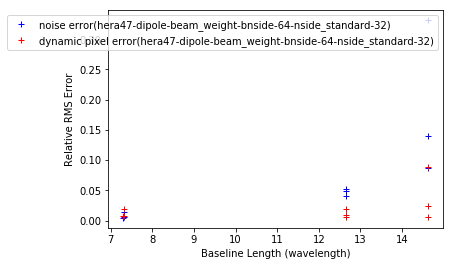

Normalization from visibilities 0.99999999999974


In [102]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((tlist - lst_offset)%24.+lst_offset)
	asrt = np.argsort((tlist - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))),  np.max(fun(cadd[u, p]))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization


Del=True
if Del:
	del(cdata)
	del(cNi)
	del(cdynamicmodel)

sys.stdout.flush()


In [103]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [104]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [105]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	else:
		I_supress = 1.
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000023 minutes used


In [106]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
rcond_list = 10.**np.arange(-12., -2., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top og AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue


Allocating AtNiA...
Computing AtNiA... 2018-02-22 23:21:00.925256
Estimated time for A 2160 by 8118 1.85052602592 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.0mins 0.163862 minutes used
Computing Regularized AtNiAi, 2018-02-22 23:21:11.476708, expected time 0.5 min trying 1e-12 0.176443 minutes used
regularization stength (710.7620943646992+0j) median GSM ranges between 284.50713487375765 284.50713487375765


Applying Regularized AtNiAi... Memory usage: 7020015.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p8118_n32_32_b64_2.000_v1.0


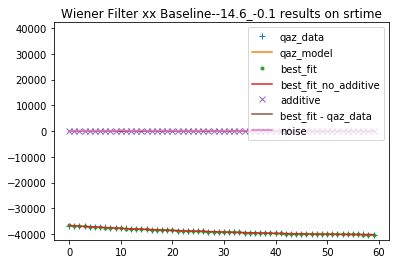

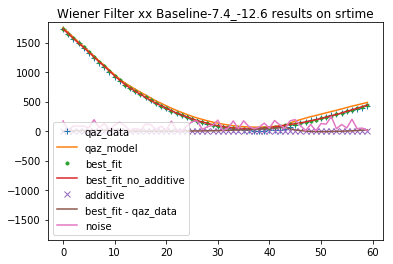

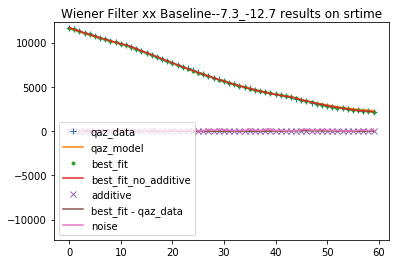

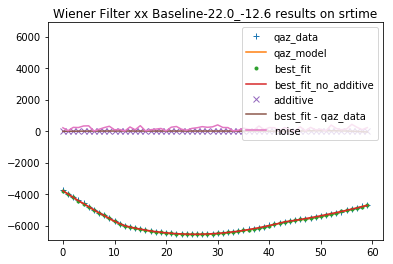

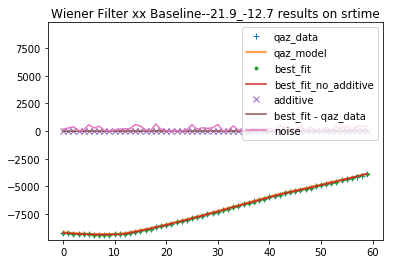

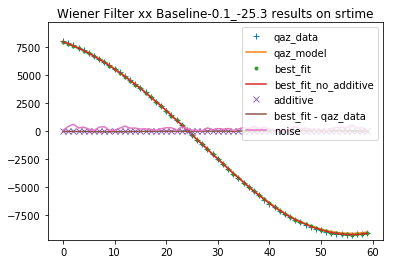

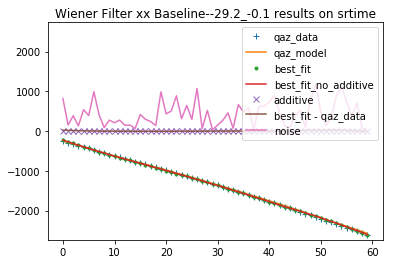

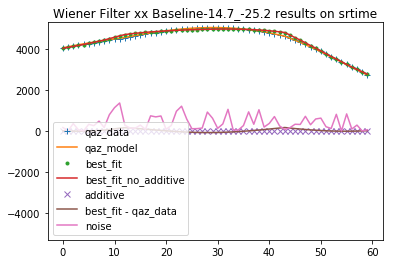

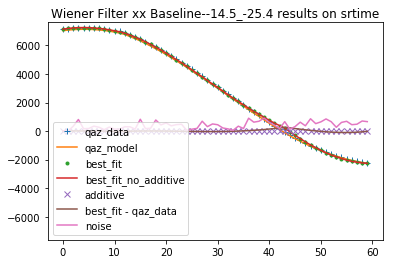

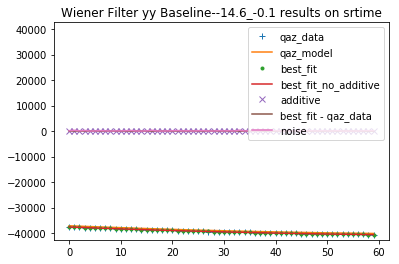

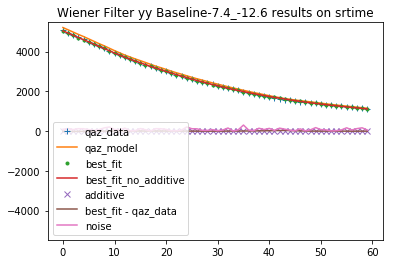

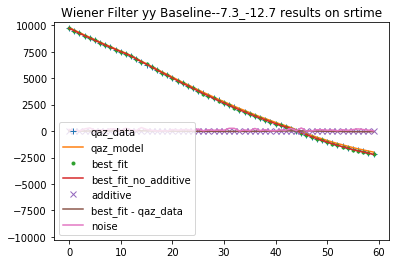

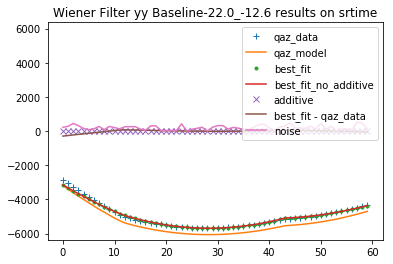

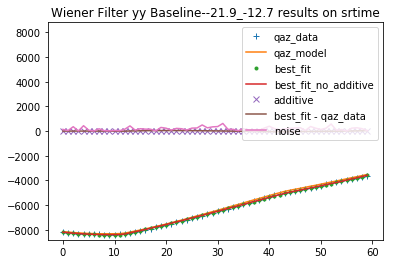

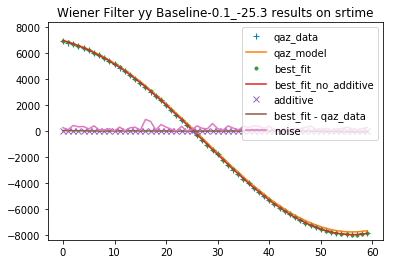

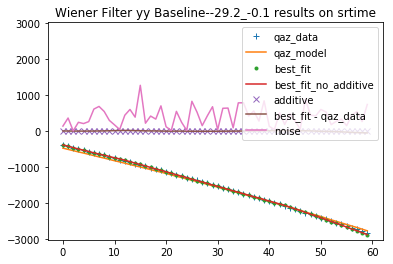

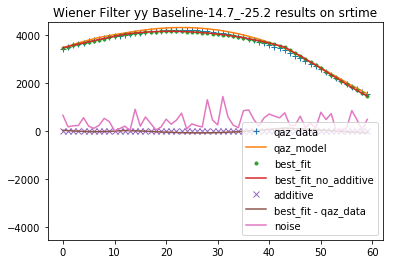

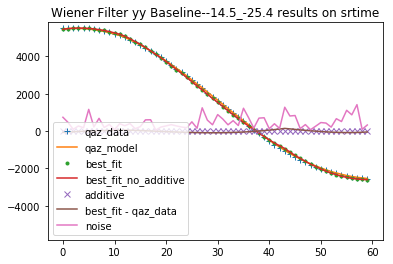

In [107]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)
A = get_A()
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()
#	for p in range(2):
#		plt.figure(10*p + 80)
#		for nu, u in enumerate(us):
#			
#			plt.subplot(6, (len(us) + 5) / 6, nu + 1)
#			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
#			plt.plot(qaz_data[ri, u, p])
#			plt.plot(qaz_model[ri, u, p])
#			plt.plot(best_fit[ri, u, p])
#			plt.plot(best_fit_no_additive[ri, u, p])
#			if pre_calibrate:
#				plt.plot(qaz_add[ri, u, p])
#			if fit_for_additive:
#				plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
#			plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
#			plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
#			data_range = np.max(np.abs(qaz_data[ri, u, p]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#			plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
#		plt.savefig(script_dir + '/../Output/data_error_wiener-%s%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(p, p, INSTRUMENT, bnside, nside_standard))
#		plt.show(block=False)
#		#plt.gcf().clear()
#		#plt.close()
	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 100*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(best_fit_no_additive[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(best_fit_no_additive[ri, u, p])), np.max(np.abs(qaz_add[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'best_fit_no_additive', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(best_fit_no_additive[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'best_fit_no_additive', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()



In [108]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	if col == shape[0] * shape[1]:
		plt.show(block=False)


In [109]:
vis_normalization

0.99999999999974

divide by zero encountered in log10


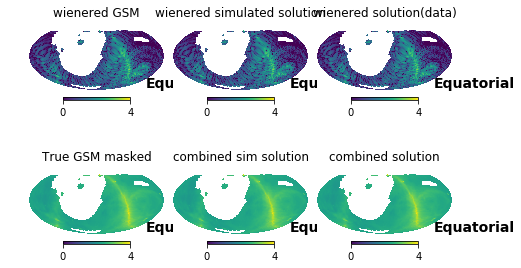

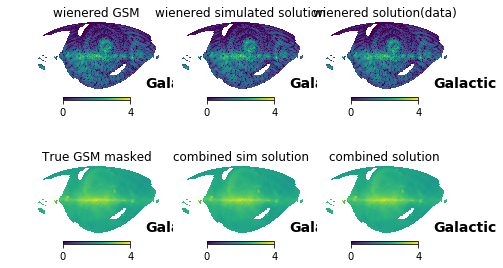

In [110]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


divide by zero encountered in log10


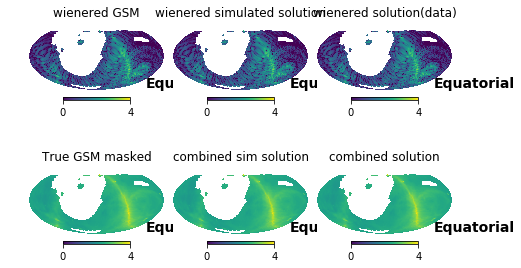

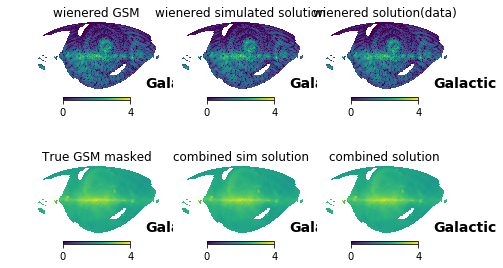

In [111]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution/vis_normalization), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 3.308e+02, data points 2160, pixels 8118
re/im chi2 1.615e+02, 1.693e+02
xx/yy chi2 1.975e+02, 1.333e+02


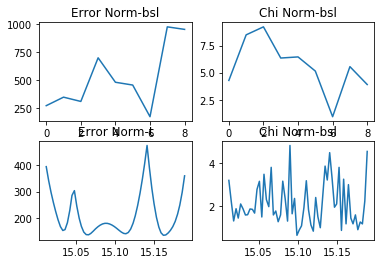

In [112]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(tlist, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(tlist, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 1.0698877043520681e-17
1.5707963267948966 -1.9401435232289192e-17
1.5707963267948966 2.0966678434668047e-17


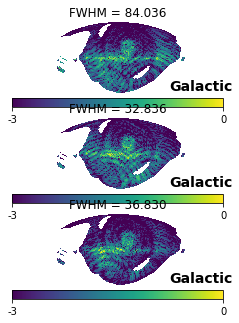

In [113]:
#S_type = 'none'
#point spread function:
if True: #and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [114]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2016_01_20_avgx100_noaddA_dI_u9_t60_p8118_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p8118_n32_32_b64_2.000_v1.0
AtNiA_N_2016_01_20_avgx100_noadd


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 1.0698877043520681e-17


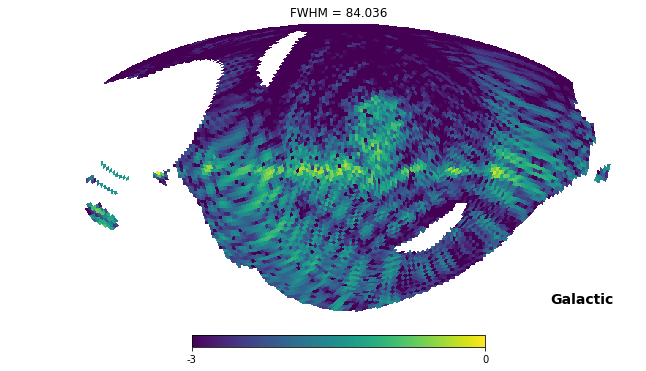

1.5707963267948966 1.0698877043520681e-17


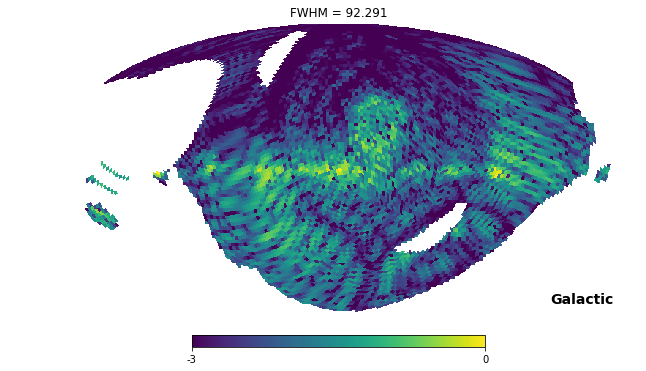

1.5707963267948966 1.0231515057949174e-18


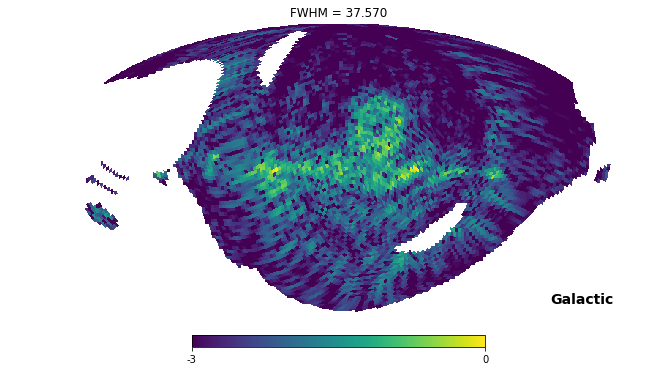

1.5707963267948966 1.0698877043520681e-17


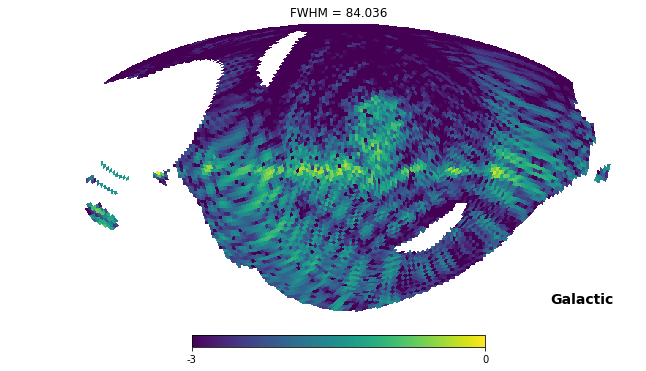

1.5707963267948966 1.405854089417439e-17


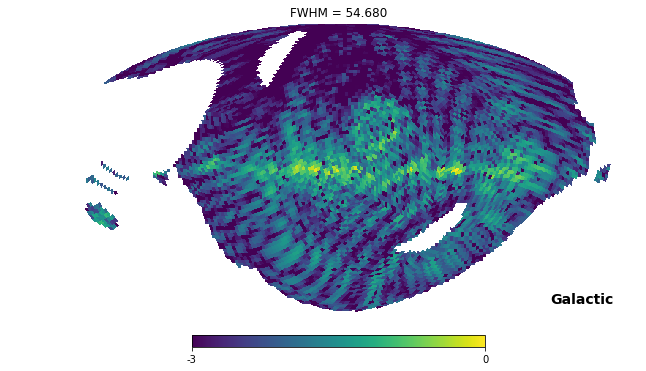

1.5707963267948966 1.0044661391681746e-17


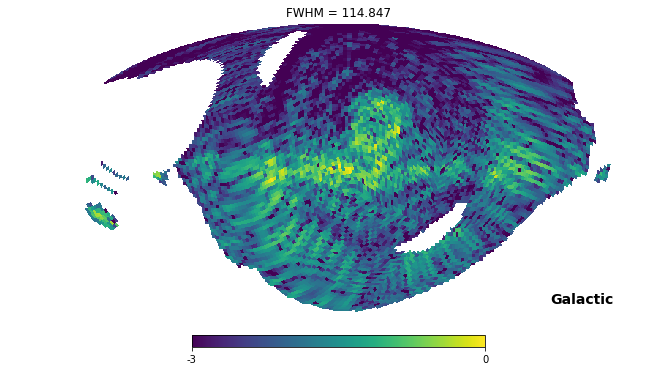

1.5707963267948966 3.885494424521741e-18


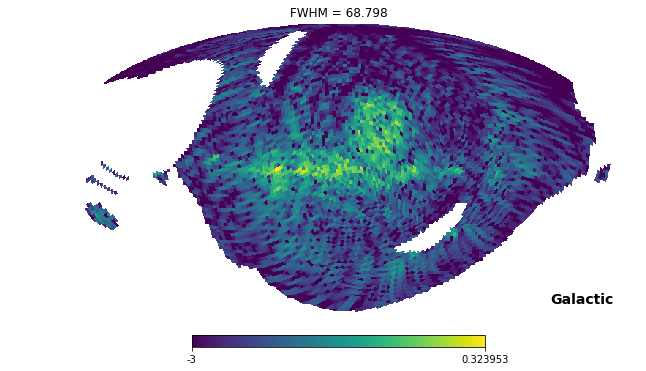

1.5707963267948966 4.2334564159933844e-19


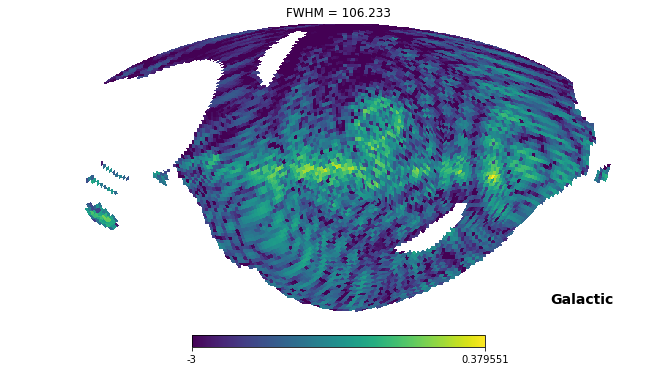

1.5707963267948963 1.0835546190604482e-17


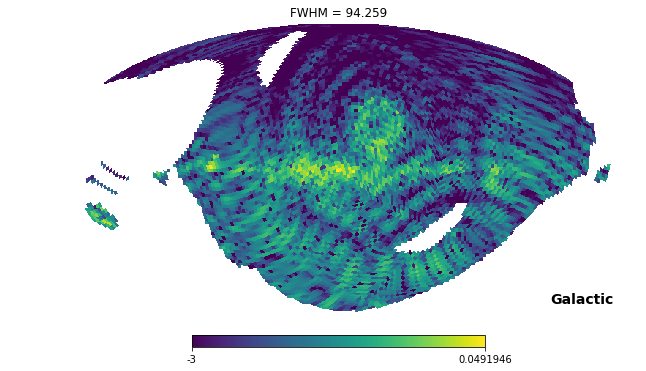

1.5707963267948966 0.0


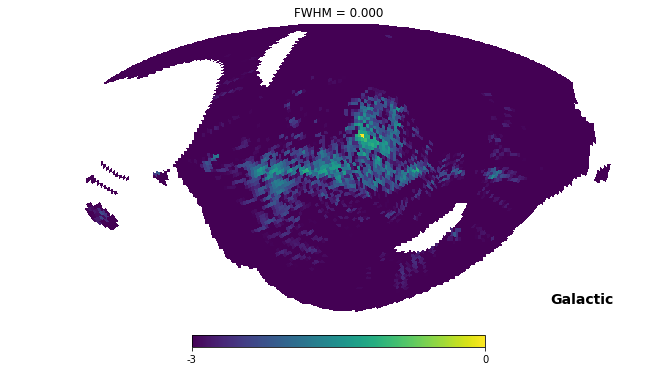

1.5707963267948966 -8.2064239534207e-18


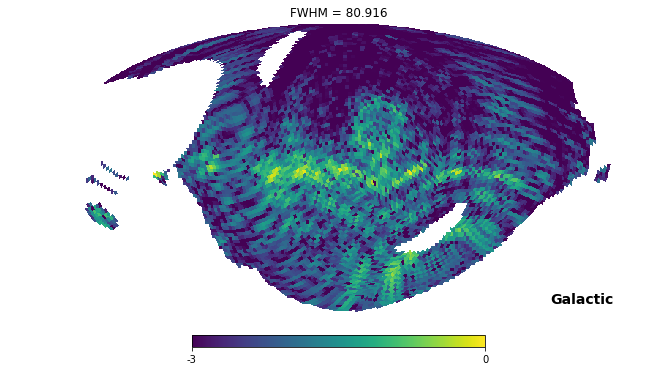

1.5707963267948966 -1.6733011320668628e-17


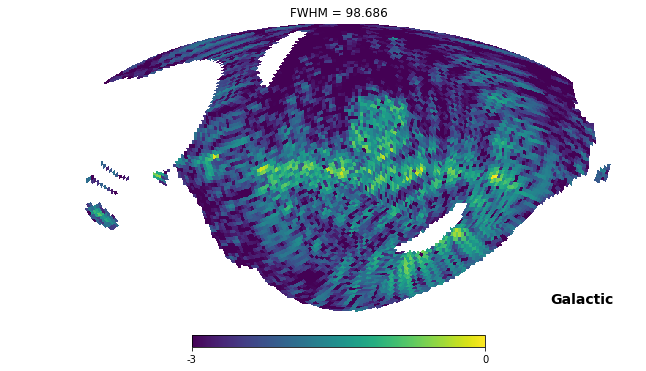

1.5707963267948966 1.96081371944202e-18


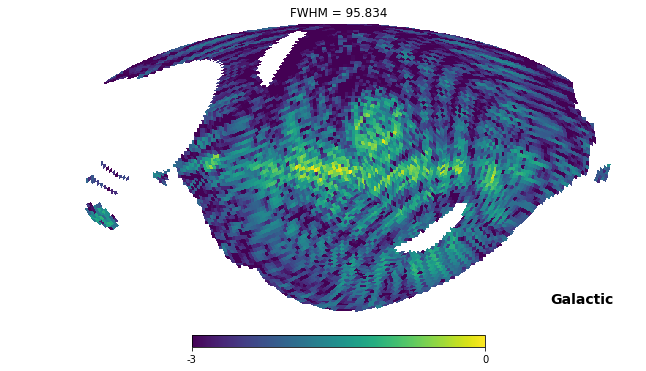

1.5707963267948966 1.7355391572658693e-17


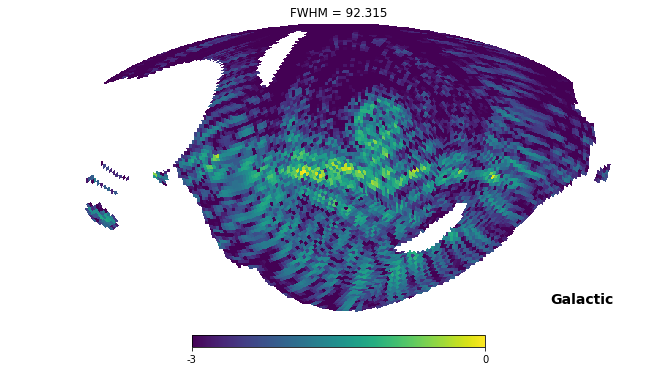

In [115]:
#S_type = 'none'
#point spread function:
if True: #and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


In [116]:
point_vec

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])